In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import string
from bs4 import BeautifulSoup
import json
import numpy as np

In [2]:
with open("/content/drive/MyDrive/Sarcasm-Detector/Sarcasm.json",'r') as input:
  data = json.load(input)
print(len(data))

26709


In [3]:
## Use NLTK's Stopword List
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
sarcasm_sentences = []
labels = []
links = []
punctuations = str.maketrans('', '', string.punctuation)
for item in data:
  sentence = item['headline'].lower()
  sentence = sentence.replace(",", " , ").replace(".", " . ").replace("-", " - ").replace("/", " / ")
  sentence = BeautifulSoup(sentence, "html.parser").get_text()

  words = sentence.split()
  filtered_sentence = ""

  for word in words:
    word = word.translate(punctuations)
    if word not in stopwords:
      filtered_sentence += word + " "
  sarcasm_sentences.append(filtered_sentence)
  labels.append(item['is_sarcastic'])
  links.append(item['article_link'])

In [5]:
print(len(sarcasm_sentences))

26709


In [6]:
training_size = 24000
vocab_size = 20000
maxlen = 40
training_sentences = sarcasm_sentences[0:training_size]
training_labels = labels[0:training_size]
testing_sentences = sarcasm_sentences[training_size:]
testing_labels = labels[training_size:]

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequence = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequence, maxlen=maxlen, padding='post', truncating='post')
testing_sequence = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequence, maxlen=maxlen, padding='post', truncating='post')

In [8]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels).astype(np.float32).reshape(-1)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels).astype(np.float32).reshape(-1)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',   # You can also monitor 'val_accuracy'
    patience=8,           # Stop after 10 epochs of no improvement
    restore_best_weights=True
)


In [10]:
model = tf.keras.Sequential([
          tf.keras.layers.Embedding(input_dim=20000, output_dim=16, input_length=maxlen),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
          tf.keras.layers.Dense(32, activation='relu'),
          tf.keras.layers.Dense(1, activation='sigmoid')
        ])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
              )
model.build(input_shape=(None, maxlen))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 16)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        41,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365,633 (1.39 MB)

 Trainable params: 365,633 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(training_padded, training_labels,
                    epochs=30,
                    validation_data=(testing_padded, testing_labels),
                    callbacks=[early_stop],
                    batch_size=32
                  )

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6724 - loss: 0.5738 - val_accuracy: 0.8092 - val_loss: 0.4144
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9016 - loss: 0.2459 - val_accuracy: 0.8125 - val_loss: 0.4161
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9516 - loss: 0.1351 - val_accuracy: 0.8195 - val_loss: 0.5018
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9786 - loss: 0.0654 - val_accuracy: 0.8084 - val_loss: 0.6006
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9871 - loss: 0.0398 - val_accuracy: 0.7988 - val_loss: 0.8567
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9932 - loss: 0.0234 - val_accuracy: 0.7996 - val_loss: 0.9508
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9949 - loss: 0.0151 - val_accuracy: 0.7866 - val_loss: 1.0161
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9974 - loss: 0.0101 - val_accuracy:

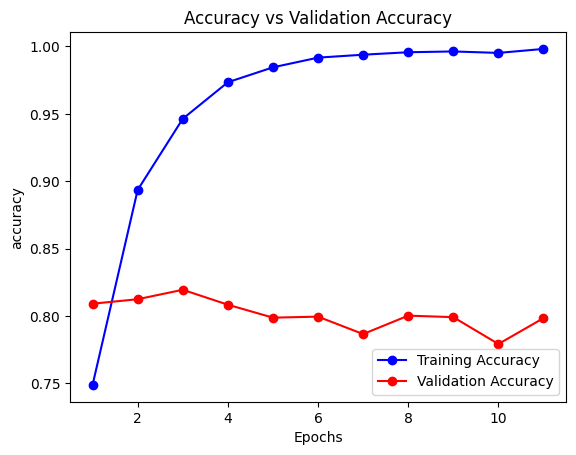

In [12]:
## plotting accuracy vs validation accuracy
import matplotlib.pyplot as plt

def plot_accuracy(history):
  acc = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
  plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
  plt.title("Accuracy vs Validation Accuracy")
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('accuracy')
  plt.show()
plot_accuracy(history)

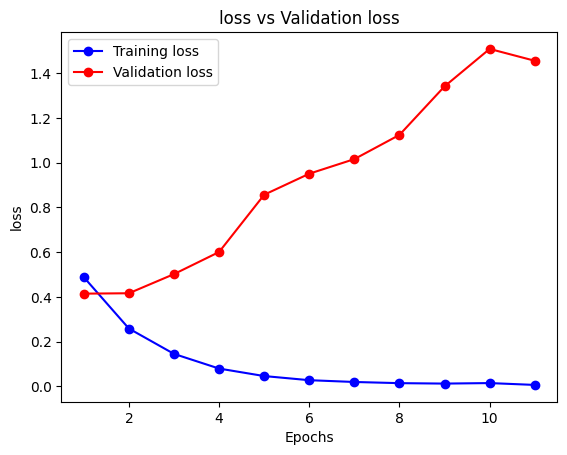

In [13]:
## plotting loss vs validation loss
import matplotlib.pyplot as plt

def plot_accuracy(history):
  acc = history.history['loss']
  val_accuracy = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo-', label='Training loss')
  plt.plot(epochs, val_accuracy, 'ro-', label='Validation loss')
  plt.title("loss vs Validation loss")
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('loss')
  plt.show()
plot_accuracy(history)

## Reducing Overfitting in Language Models

In [14]:
from tensorflow.keras.optimizers import Adam

model = tf.keras.Sequential([

          ## Exploring embedding dimensions
          tf.keras.layers.Embedding(vocab_size, 16),
          tf.keras.layers.SpatialDropout1D(0.3),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
          tf.keras.layers.GlobalAveragePooling1D(),

          ## Using regularization
          tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),

          ## Using Dropout
          tf.keras.layers.Dropout(.3),
          tf.keras.layers.Dense(1, activation='sigmoid')
        ])

## Adjusting the learning rate
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.00003,beta_1=0.90, beta_2=0.999, amsgrad=False),
              metrics=['accuracy']
              )
history = model.fit(
    training_padded, training_labels,
    epochs=30,
    validation_data=(testing_padded, testing_labels),
    callbacks=[early_stop],
    batch_size=32
)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.5580 - loss: 1.1565 - val_accuracy: 0.5748 - val_loss: 1.0385
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5590 - loss: 1.0126 - val_accuracy: 0.5748 - val_loss: 0.9284
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5549 - loss: 0.9117 - val_accuracy: 0.5748 - val_loss: 0.8459
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.5681 - loss: 0.8274 - val_accuracy: 0.6884 - val_loss: 0.6967
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7571 - loss: 0.6437 - val_accuracy: 0.7279 - val_loss: 0.6288
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7889 - loss: 0.5627 - val_accuracy: 0.7571 - val_loss: 0.5766
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8077 - loss: 0.5082 - val_accuracy: 0.7748 - val_loss: 0.5367
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8242 - loss: 0.4639 - val_acc

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
preds = (model.predict(testing_padded) > 0.5).astype("int32")
print(confusion_matrix(testing_labels, preds))
print(classification_report(testing_labels, preds))

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[[1328  229]
 [ 307  845]]
              precision    recall  f1-score   support

         0.0       0.81      0.85      0.83      1557
         1.0       0.79      0.73      0.76      1152

    accuracy                           0.80      2709
   macro avg       0.80      0.79      0.80      2709
weighted avg       0.80      0.80      0.80      2709



## Making Prediction

In [16]:
sarcastic_sentences = [
    "Oclinton becomes first president to clear 18 feet in pole vault",
    "I love when my phone dies in the middle of a call—super convenient.",
    "Wow, you finally showed up. Only took you all day.",
    "Of course I studied for the test—I just enjoy failing.",
    "Fantastic! Traffic jam right before my big meeting!",
    "Nothing beats working all weekend. So relaxing!",
    "Yeah, because binge-watching Netflix all night was a great life decision.",
    "I totally wanted to spill coffee on my white shirt today.",
    "Sure, I *meant* to send that embarrassing text to my boss.",
    "Perfect! The internet went down right when I started my assignment."
]

In [17]:
sequences1 = tokenizer.texts_to_sequences(sarcastic_sentences)
padded1 = pad_sequences(sequences1, maxlen=maxlen, padding="post", truncating="post")
print("sarcastic_sentences Prediction")

print(model.predict(padded1))

sarcastic_sentences Prediction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[[0.8530793 ]
 [0.82075405]
 [0.24349327]
 [0.9327491 ]
 [0.08125715]
 [0.96255755]
 [0.5749981 ]
 [0.9316684 ]
 [0.8632186 ]
 [0.22298309]]


In [18]:
non_sarcastic_sentences = [
    "I went to the store to buy some groceries.",
    "She enjoys reading mystery novels on the weekend.",
    "The weather is pleasant today, sunny and warm.",
    "He completed the assignment before the deadline.",
    "We had a great time at the park yesterday.",
    "I like how this app helps me stay organized.",
    "They are planning a trip to New York next month.",
    "I’m learning how to cook Italian food.",
    "The cat sat quietly by the window.",
    "She smiled when she saw the surprise gift."
]

In [19]:
sequences2 = tokenizer.texts_to_sequences(non_sarcastic_sentences)
padded2 = pad_sequences(sequences2, maxlen=maxlen, padding="post", truncating="post")
print("non_sarcastic_sentences Prediction")
print(model.predict(padded2))

non_sarcastic_sentences Prediction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[0.64532566]
 [0.8755512 ]
 [0.9011858 ]
 [0.6795259 ]
 [0.95064616]
 [0.12060548]
 [0.9201958 ]
 [0.2695701 ]
 [0.9679621 ]
 [0.78972006]]


## Using Pretrained Emnbedding from TensorFlow Hub

In [20]:
# Prepare data
training_size = 24000
training_sentences = sarcasm_sentences[0:training_size]
testing_sentences = sarcasm_sentences[training_size:]
training_labels = np.array(labels[0:training_size]).astype(np.float32)
testing_labels = np.array(labels[training_size:]).astype(np.float32)

In [23]:
import tensorflow_hub as hub

embedding_url = "https://kaggle.com/models/google/gnews-swivel/frameworks/TensorFlow2/variations/tf2-preview-20dim/versions/1"

inputs = tf.keras.Input(shape=(), dtype=tf.string)
x = hub.KerasLayer(embedding_url, trainable=True)(inputs)
x = tf.keras.layers.Dense(16, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

TypeError: Exception encountered when calling layer 'keras_layer_1' (type KerasLayer).

Binding inputs to tf.function failed due to `A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```
`. Received args: (<KerasTensor shape=(None,), dtype=string, sparse=False, name=keras_tensor_14>,) and kwargs: {} for signature: (sentences: TensorSpec(shape=(None,), dtype=tf.string, name=None)).

Call arguments received by layer 'keras_layer_1' (type KerasLayer):
  • inputs=<KerasTensor shape=(None,), dtype=string, sparse=False, name=keras_tensor_14>
  • training=None

In [ ]:
from keras.saving import save_model
save_model(model, '/content/drive/MyDrive/Sarcasm-Detector/sarcasm.keras')